In [ ]:
%matplotlib inline


Classifying Names with a Character-Level RNN


In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-02-06 19:29:17--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.33.56, 99.86.33.48, 99.86.33.64, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.33.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.06s   

2020-02-06 19:29:22 (46.1 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.tx

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/Greek.txt', 'data/names/German.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Portuguese.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/French.txt', 'data/names/Arabic.txt', 'data/names/Italian.txt', 'data/names/Korean.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Dutch.txt']


In [ ]:

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [ ]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [ ]:
category_lines = {}
all_categories = []


for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Transform surnames into tensor
--------------------------




In [ ]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Model


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9541, -2.9072, -2.8487, -2.8370, -2.9305, -2.8191, -2.9025, -2.8832,
         -2.8777, -2.8200, -2.8107, -2.7927, -2.9285, -2.9852, -2.9884, -2.9442,
         -2.9069, -2.9207]], grad_fn=<LogSoftmaxBackward>)


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 11)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Urbanovska
category = Korean / line = Ha
category = Vietnamese / line = Sai
category = Scottish / line = Craig
category = Scottish / line = Clark
category = Spanish / line = Narvaez
category = Czech / line = Camfrlova
category = Irish / line = Cassidy
category = Vietnamese / line = Nguyen
category = Vietnamese / line = Tieu


In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

   
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [ ]:
n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

   
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s)  %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (2.604567289352417)  Ueda / Chinese ✗ (Japanese)
10000 10% (2.966215133666992)  Helashvili / Italian ✗ (Russian)
15000 15% (4.1753034591674805)  Gefter / German ✗ (Russian)
20000 20% (1.3968206644058228)  Ling / Chinese ✓
25000 25% (2.3484721183776855)  Granger / German ✗ (English)
30000 30% (2.223210334777832)  Hunter / German ✗ (Scottish)
35000 35% (4.476291656494141)  Morcos / Portuguese ✗ (Arabic)
40000 40% (1.785630464553833)  Delgado / Spanish ✗ (Portuguese)
45000 45% (1.7619911432266235)  Campo / Italian ✗ (Spanish)
50000 50% (1.3568942546844482)  Sergeant / French ✓
55000 55% (1.8388346433639526)  Rheem / Chinese ✗ (Korean)
60000 60% (1.3900723457336426)  Tatsuno / Italian ✗ (Japanese)
65000 65% (0.7205301523208618)  Apeldoorn / Dutch ✓
70000 70% (3.415874481201172)  Sioda / Portuguese ✗ (Irish)
75000 75% (2.1507375240325928)  Haase / Japanese ✗ (German)
80000 80% (0.33630096912384033)  Tadhgan / Irish ✓
85000 85% (1.6683368682861328)  Elvin / Irish ✗ (English)
90000 90

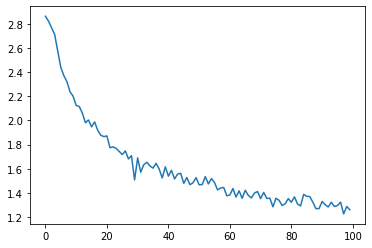

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Analysis of result


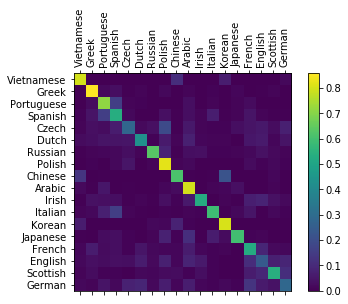

In [ ]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1


for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)


ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

Model Test
---------------------




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.91) Czech
(-1.01) Russian
(-2.16) English

> Jackson
(-0.68) Scottish
(-1.18) English
(-3.04) Russian

> Satoshi
(-1.13) Japanese
(-1.75) Italian
(-1.96) Arabic


In [ ]:

#add linear layers
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8965, -2.8330, -2.9486, -2.8830, -2.8302, -2.9100, -2.8248, -2.8768,
         -2.8525, -2.8862, -2.9631, -2.8911, -2.9792, -2.8871, -2.8745, -2.8892,
         -2.8425, -2.9783]], grad_fn=<LogSoftmaxBackward>)


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Russian', 6)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Sarkis
category = Arabic / line = Haik
category = Dutch / line = Vennen
category = Arabic / line = Bishara
category = Korean / line = Suk
category = Korean / line = Yun
category = French / line = Felix
category = Irish / line = Rinn
category = Portuguese / line = Garcia
category = Greek / line = Sklavenitis


In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [ ]:
n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s)  %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (2.9884555339813232)  Noh / Vietnamese ✗ (Korean)
10000 10% (3.0776968002319336)  Valtchitski / Italian ✗ (Russian)
15000 15% (2.463115930557251)  Kennedy / Russian ✗ (Scottish)
20000 20% (1.5642459392547607)  Lieu / Vietnamese ✓
25000 25% (1.0278629064559937)  Belesis / Greek ✓
30000 30% (1.2268054485321045)  Kaberov / Russian ✓
35000 35% (0.846987247467041)  Hlopiev / Russian ✓
40000 40% (0.7327351570129395)  Mar / Chinese ✓
45000 45% (2.743678092956543)  Palzewicz / Spanish ✗ (Czech)
50000 50% (0.7044620513916016)  Haddad / Arabic ✓
55000 55% (0.9352912902832031)  Ryom / Korean ✓
60000 60% (3.721798896789551)  Kouba / Arabic ✗ (Czech)
65000 65% (2.770674228668213)  Osladil / Russian ✗ (Czech)
70000 70% (1.1335422992706299)  O'Keeffe / Irish ✓
75000 75% (0.276928186416626)  Tsapaev / Russian ✓
80000 80% (1.6325026750564575)  Robertson / Scottish ✗ (English)
85000 85% (0.8508782982826233)  Geier / German ✓
90000 90% (1.6284624338150024)  Kidd / Scottish ✗ (English)
95000 95% (

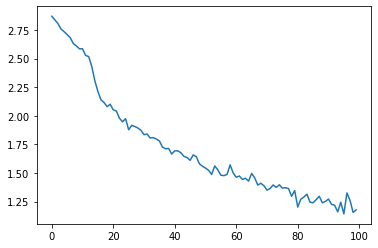

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

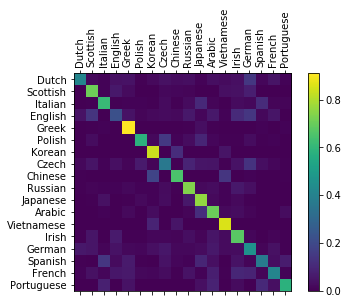

In [ ]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1


for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)


ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Smith')
predict('Satoshi')


> Dovesky
(-0.42) Russian
(-1.88) Czech
(-2.71) Polish

> Smith
(-1.01) Scottish
(-1.19) German
(-2.39) English

> Satoshi
(-0.14) Japanese
(-2.10) Arabic
(-5.38) Russian


2part:  Add nn.LSTM


In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTM(input_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        output, hidden = self.i2h(input)
        output = self.i2o(output[-1])
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
        
n_hidden = 128
model_2 = LSTM(n_letters, n_hidden, 18)

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, 1, n_hidden)

output, next_hidden = model_2(input)
print(output)

tensor([[-2.9187, -2.9315, -2.9028, -2.8593, -2.8884, -2.8935, -2.8745, -2.9272,
         -2.8155, -2.9059, -2.8504, -2.8931, -2.9651, -2.8781, -2.8955, -2.8646,
         -2.8725, -2.8999]], grad_fn=<LogSoftmaxBackward>)


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 8)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Eatherington
category = Arabic / line = Malouf
category = French / line = Deniaud
category = Greek / line = Spyridis
category = Spanish / line = Viteri
category = Greek / line = Giannakos
category = Scottish / line = Crawford
category = Arabic / line = Handal
category = German / line = Kneller
category = Dutch / line = Philips


In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = model_2.initHidden()

    model_2.zero_grad()

    
    output, hidden = model_2(line_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in model_2.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [ ]:
n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s)  %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (2.7126095294952393)  Tatsuya / Japanese ✓
10000 10% (2.9761617183685303)  Martel / Japanese ✗ (French)
15000 15% (2.7962002754211426)  Nikolaou / English ✗ (Greek)
20000 20% (2.5878713130950928)  La / Vietnamese ✓
25000 25% (2.8336269855499268)  Kaluza / Spanish ✗ (Polish)
30000 30% (3.634456157684326)  Maciomhair / Greek ✗ (Irish)
35000 35% (1.4406832456588745)  Yeo / Korean ✓
40000 40% (1.3013176918029785)  Ryu / Chinese ✗ (Korean)
45000 45% (3.645355224609375)  Bolivar / French ✗ (Spanish)
50000 50% (0.34945133328437805)  Sotiris / Greek ✓
55000 55% (0.6572207808494568)  Dubanowski / Polish ✓
60000 60% (1.44728684425354)  Vico / Italian ✓
65000 65% (2.0767552852630615)  Vickers / Dutch ✗ (English)
70000 70% (1.7997946739196777)  Nader / French ✗ (Arabic)
75000 75% (0.8108288049697876)  Pereira / Portuguese ✓
80000 80% (2.3005905151367188)  Salazar / Arabic ✗ (Portuguese)
85000 85% (1.3318071365356445)  Snaijer / Dutch ✓
90000 90% (0.9897196888923645)  Schumacher / German ✓


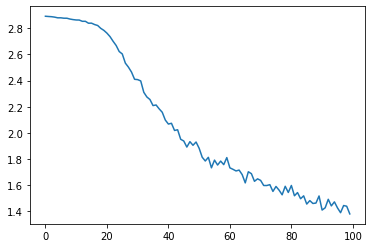

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

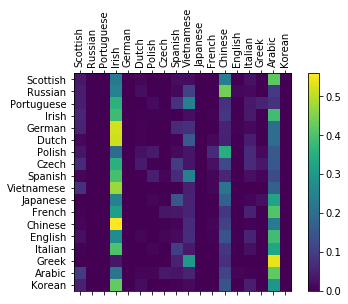

In [ ]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1


for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)


ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


3rd part: LSTM+RNN


In [ ]:
import torch.nn as nn

class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        output, hidden = self.lstm(input)
        output, hidden = self.rnn(output, hidden[0])
        output = self.linear(output[-1])
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

n_hidden = 128
model_3 = RNN_LSTM(n_letters, n_hidden, n_categories)



In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, 1, n_hidden)

output, next_hidden = model_3(input)
print(output)

tensor([[-0.0103,  0.1060,  0.0870, -0.0341,  0.0685,  0.0284,  0.0148,  0.0402,
         -0.0410, -0.0976, -0.0789,  0.0644,  0.0026,  0.0032,  0.0038,  0.0150,
          0.0559,  0.0290]], grad_fn=<AddmmBackward>)


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 1)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Abarca
category = English / line = Fowley
category = Polish / line = Wawrzaszek
category = Polish / line = Pokorny
category = Italian / line = Serafini
category = Portuguese / line = Pinheiro
category = Chinese / line = Shu
category = Polish / line = Dziedzic
category = Korean / line = Jung 
category = Spanish / line = Agramunt


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = model_3.initHidden()

    model_3.zero_grad()

    
    output, hidden = model_3(line_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in model_3.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [ ]:
n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s)  %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (1.3195348978042603)  Yu / Korean ✓
10000 10% (2.499748706817627)  Chepurov / Polish ✗ (Russian)
15000 15% (2.882319450378418)  Palomo / Portuguese ✗ (Spanish)
20000 20% (1.8064831495285034)  Rahal / Arabic ✓
25000 25% (3.257599353790283)  Tkachuk / Irish ✗ (Russian)
30000 30% (1.0292549133300781)  Youn / Chinese ✗ (Korean)
35000 35% (3.090911388397217)  Moghadam / Russian ✗ (Arabic)
40000 40% (0.8916152715682983)  Mo / Korean ✓
45000 45% (3.59672212600708)  Mateu / Korean ✗ (Spanish)
50000 50% (2.826964855194092)  Eoin / Vietnamese ✗ (Irish)
55000 55% (2.163457155227661)  Holub / Arabic ✗ (Czech)
60000 60% (1.6812336444854736)  Abel / German ✓
65000 65% (0.34758636355400085)  Assaf / Arabic ✓
70000 70% (0.8263110518455505)  Grant / Scottish ✓
75000 75% (0.005832201801240444)  Shirmanov / Russian ✓
80000 80% (4.447829723358154)  Renard / Dutch ✗ (Russian)
85000 85% (0.2669619023799896)  Tolvinsky / Russian ✓
90000 90% (0.2756480574607849)  Portyanik / Russian ✓
95000 95% (4.737

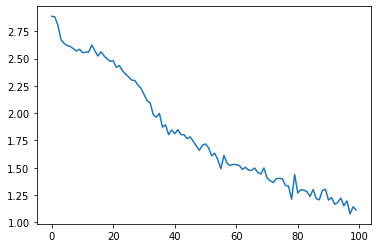

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)